In [35]:
#import

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.optimize import minimize

In [52]:
#parameter

ng = 1.452 #diffractive index of glass
lam = 852e-9 #wave length[m]
R = 75e-3 #curvature radius[m]
L = 5e-3 #length of cavity[m]
f = np.array([30,40,50,75,100,125,150,200,250,300,400,500])*1e-3 #focus length[m]

In [37]:
#stability condition of FilterCavity

def stabCal(L,R,n,lam):
    ML = np.array([[1,L],[0,1]])
    MR = np.array([[1,0],[-2/R,1]]) #曲面鏡での反射

    M = np.matmul(MR,ML)
    M = np.matmul(ML,M)

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    R_cav = 2*B/(D-A)
    Omega_cav = np.sqrt(2*B*lam/(np.pi*n*np.sqrt(4-(A+D)**2)))
    return R_cav, Omega_cav

R_cav = stabCal(L,R,ng,lam)[0]
print("R_cav=",R_cav,"[m]")
Omega_cav = stabCal(L,R,ng,lam)[1]
print("Omega_cav=",Omega_cav,"[m]")

R_cav= inf [m]
Omega_cav= 5.9112396135854004e-05 [m]


C:\Users\basas\AppData\Local\Temp\ipykernel_17352\1033302298.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  R_cav = 2*B/(D-A)


この結果からlens cavityでは入射面においてbeam waistが来るようにし,なおかつそのbeam waistを所望のsizeに変換する必要があることがわかった.\
そのbeam径の変換はlensによっておこなう. 以下では,そのlensの焦点距離と位置を見積もっていく.\
見積もりの方法はlensの数:one or twoとlen前のbeamのcollimationの状態が完全と仮定するか否かによって、4通りの方法がある.

# Perfect collimation condition (for one lens)

lensに入射する光が完全に平行光であると仮定すると, lensの置く位置はlensの入射面から焦点距離:fだけ後ろに置けばいいことになる.\
(beam waistの位置=lensから焦点距離離れた位置だから)\
この仮定の下で元のbeam radiusと測定し,各焦点距離のlensで絞った後のbeam radius: Omega_dashを計算する.\
その値がOmega_cavに最も近いlensを採用するという方針である.

In [5]:
def matrixCal(Omega,f,n):
    Mf = np.array([[1,0],[-1/f,1]])
    Md = np.array([[1,f],[0,1]])
    Mn = np.array([[1,0],[0,1/n]]) #自由空間からlensに入射する時の平面境界での屈折

    M=np.matmul(Md,Mf)
    M=np.matmul(Mn,M)
    
    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    q_in = 1j*np.pi*Omega**2/lam
    q_out = (A*q_in+B)/(C*q_in+D)
    Omega_dash = np.sqrt(q_out.imag*lam/np.pi)
    return Omega_dash

In [6]:
for i in f:
    print("f=",int(i*1e3),"[mm]:",matrixCal(895e-6/2,i,ng),"[m]")

f= 30 [mm]: 2.188986640298862e-05 [m]
f= 40 [mm]: 2.9167802221915518e-05 [m]
f= 50 [mm]: 3.642978701715861e-05 [m]
f= 75 [mm]: 5.448946505099447e-05 [m]
f= 100 [mm]: 7.236582497641218e-05 [m]
f= 150 [mm]: 0.00010734713467807124 [m]
f= 200 [mm]: 0.00014097334704654528 [m]


# Imperfect collimation condition (for one lens)

lensに入射する光が平行光ではないとすると,1つ前のpefect collimation conditionの場合と異なり,lemsからcavityまでの距離:d2がfと一致するとは限らなくなる.\
この場合,まず,lensで絞る前のガウシアンビームのビーム形状を知る必要があるので,beam profilerで3～5点でのbeam radiusを測定し,beam waistの位置とspot sizeを計算する.\
そして,そこで計算したようなガウシアンビームを各焦点距離:fのlensで絞った後のbeam radius: Omega_dashがOmega_cavと一致するようにd1,d2を最適化する.

[-2.00131161e-01  8.06103951e-05]


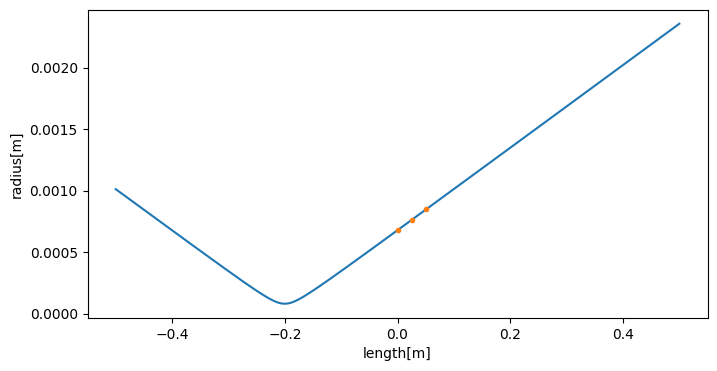

In [20]:
zs = np.array([0, 25.4, 50.8])*1e-3 #[mm]
ws = np.array([680, 760, 850])*1e-6 #[mm]

n_air = 1
lam = 852.3e-9

#任意の位置:zにおけるビーム径を
def waist(z, z0, w0):
    z_R = np.pi*w0**2*n_air/lam #Rayleigh length
    return w0*np.sqrt(1 + ((z-z0)/z_R)**2)

z = np.linspace(-500e-3, 500e-3, 1001)

popt, pcov = curve_fit(waist, zs, ws, maxfev=100000)
print(popt)

plt.figure(figsize=(8,4))
plt.plot(z, waist(z, *popt))
plt.plot(zs, ws, '.')
plt.xlabel("length[m]")
plt.ylabel("radius[m]")
plt.show()

In [21]:
Omega0 = popt[1] 
print("beam waist:",Omega0,"[m]")

beam waist: 8.061039507655238e-05 [m]


In [42]:
#one lens version  

def matrixCal(d,f,n):
    d1 = d[0]
    d2 = d[1]
    Mf = np.array([[1,0],[-1/f,1]])
    Md1 = np.array([[1,d1],[0,1]])
    Md2 = np.array([[1,d2],[0,1]])
    Mn = np.array([[1,0],[0,1/n]]) #自由空間からlensに入射する時の平面境界での屈折

    M=np.matmul(Mf,Md1)
    M=np.matmul(Md2,M)
    M=np.matmul(Mn,M)
    
    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    q_in = 1j*np.pi*Omega0**2/lam
    q_out = (A*q_in+B)/(C*q_in+D)
    Omega_dash = np.sqrt(q_out.imag*lam/np.pi)
    return Omega_dash, D-A

#目的関数(これを最小化することでパラメータが最適化される)
def objective(d,f,n):
    diameter_error = (matrixCal(d,f,n)[0]- Omega_cav)**2
    return diameter_error

In [33]:
def curvature_constraint(d,f,ng):
    current_curvature_radius = matrixCal(d,f,ng)[1]
    return current_curvature_radius

In [62]:
bounds = [(0.2, 0.6), (0, 0.3)]  # d1とd2の範囲
initial_guess = [(bounds[0][0]+bounds[0][1])/2, (bounds[1][0]+bounds[1][1])/2]  # d1とd2の初期値

In [63]:
for i in f:
    #制約の定義
    constraints = {
    'type': 'eq',  #等式制約
    'fun': curvature_constraint,
    'args': (i,ng)
    }
    result = minimize(objective, initial_guess, args=(i,ng), bounds=bounds, constraints=constraints)
    if result.success:
        optimized_d1, optimized_d2 = result.x
        final_diameter = matrixCal([optimized_d1,optimized_d2],i,ng)[0]
        final_curvature = matrixCal([optimized_d1,optimized_d2],i,ng)[1]
        print("focus length",i*1e3,"[mm]")
        print(f"Optimized d1: {optimized_d1*1e3}[mm], Optimized d2: {optimized_d2*1e3}[mm]")
        print(f"Final diameter: {final_diameter}, Final curvature radius: {final_curvature}")
        #print(f"Final objective function value: {result.fun}")
    else:
        print("focus length",i)
        print("Optimization failed")


focus length 30.0 [mm]
Optimized d1: 337.02031598955244[mm], Optimized d2: 241.44649855829476[mm]
Final diameter: 9.462589091306006e-06, Final curvature radius: -1.903317503604285e-09
focus length 40.0 [mm]
Optimized d1: 335.56614628483806[mm], Optimized d2: 243.55795211672609[mm]
Final diameter: 1.3102594775008663e-05, Final curvature radius: 3.2480755862707156e-09
focus length 50.0 [mm]
Optimized d1: 334.1119765454172[mm], Optimized d2: 245.66940523153053[mm]
Final diameter: 1.703397031852329e-05, Final curvature radius: -2.0555774860042675e-09
focus length 75.0 [mm]
Optimized d1: 330.4765527959983[mm], Optimized d2: 250.94803930385274[mm]
Final diameter: 2.8391145091204747e-05, Final curvature radius: 2.508685259527965e-09
focus length 100.0 [mm]
Optimized d1: 326.84112953823603[mm], Optimized d2: 256.2266733396096[mm]
Final diameter: 4.258369033057615e-05, Final curvature radius: 1.0390981408647804e-09
focus length 150.0 [mm]
Optimized d1: 319.5702879394373[mm], Optimized d2: 266.7

# Perfect collimation condition (for two lens)

lensに入射する光が完全に平行光であると仮定したうえで, 焦点距離:f1のlens1, lens1とlens2間の距離:d1, 焦点距離:f2のlens2, lens2とlens cavity間の距離:d2の伝搬を光線行列で追跡する.\
元のgaussian beamを十分collimationした上で, beam radiusを測定し,それを上述の光線行列により絞った後のbeam radius: Omega_dashを計算する.\
その値がOmega_cavに最も近いlensを採用し, 位置:d2,d3を最適化するという方針である.

In [26]:
# caution: beam profiler output is diameter, not radius 
Omega0 = 6.14e-4/2 #[m]

# 光線行列
def matrixCal(d, f1, f2, n):
    d2 = d[0]
    d3 = d[1]
    Mf1 = np.array([[1, 0], [-1 / f1, 1]])
    Mf2 = np.array([[1, 0], [-1 / f2, 1]])
    Md2 = np.array([[1, d2], [0, 1]])
    Md3 = np.array([[1, d3], [0, 1]])
    Mn = np.array([[1, 0], [0, 1/n]])
    M = np.matmul(Md2, Mf1)
    M = np.matmul(Mf2, M)
    M = np.matmul(Md3, M)
    M = np.matmul(Mn, M)
    A = M[0][0]
    B = M[0][1]
    C = M[1][0]
    D = M[1][1]
    q_in = 1j * np.pi * 1 * Omega0 ** 2 / lam
    q_out = (A * q_in + B) / (C * q_in + D)
    # lens cavityにおいては,q_outもbeam waistに相当するのでq_inと同じくR=infと過程してよい
    # ※厳密には
    Omega_dash = np.sqrt(q_out.imag * lam / np.pi)
    CurvatureRadius_dash = 1/q_out.real
    return Omega_dash, CurvatureRadius_dash, D-A

# 目的関数
def objective(d, f1, f2, n):
    radius_error = (matrixCal(d, f1, f2, n)[0] - Omega0) ** 2 #二乗誤差
    return radius_error

# 曲率半径制約(D-A=0)
def curvature_constraint(d, f1, f2, n):
    return matrixCal(d, f1, f2, n)[2]

# parameter:d2,d3の範囲制約と初期値の定義
tube_length = 0.0635 #[m]
#candidate: 50.8, 63.5, 76.3, 88.9[mm]
bounds = [(tube_length*1, tube_length*1+0.033), (0.03, 0.13)]  # d2とd3の範囲[m]
initial_guess = [(bounds[0][0]+bounds[0][1])/2, (bounds[1][0]+bounds[1][1])/2]  # d2とd3の初期値[m]

# 最適化ループ
final_list = []
for i in f:  # f1
    for j in f:  # f2
        constraints = {
            'type': 'eq',  # 等式制約
            'fun': curvature_constraint,
            'args': (i, j, ng)
        }
        result = minimize(objective, initial_guess, args=(i, j, ng), bounds=bounds, constraints=constraints)
        if result.success:
            optimized_d2 = result.x[0]
            optimized_d3 = result.x[1]
            final_radius, final_curvature, _ = matrixCal([optimized_d2,optimized_d3], i, j, ng)
            final_list.append((final_radius, optimized_d2, optimized_d3, i, j, final_curvature)) #[m]


# 最適な結果を表示
if final_list:
    closest_radius = min(final_list, key=lambda x: abs(x[0] - Omega_cav))
    print("Omega cavity:", Omega_cav,"[m]")
    print(f"final radius: {closest_radius[0]}[m]")
    print(f"d2: {closest_radius[1] * 1e2} [cm], d3: {closest_radius[2] * 1e2} [cm]")
    print(f"focus length 1: {closest_radius[3] * 1e3} [mm], focus length 2: {closest_radius[4] * 1e3} [mm]")
    print(f"final cuevature radius:{closest_radius[5]}[m]")

Omega cavity: 5.414702904835464e-05 [m]
final radius: 5.8429928998333256e-05[m]
d2: 9.077160407526716 [cm], d3: 6.149547218170306 [cm]
focus length 1: 300.0 [mm], focus length 2: 100.0 [mm]
final cuevature radius:-27227938709.6508[m]


# Imperfect collimation condition (for two lens)

rayleigh length: 1.3909002842849392 [m]
waist position: -2.0905532564150757 [m]
beam waist: 0.0006142841446121676 [m]


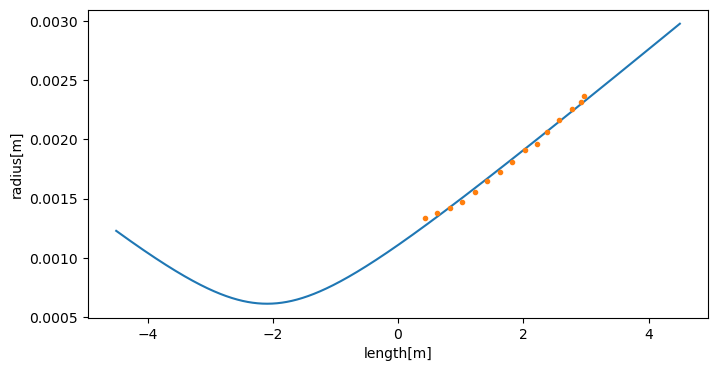

In [43]:
zs = np.array([17,25,33,41,49,57,65,73,81,89,95,103,111,117,119])*25*1e-3 #[m]
ws = np.array([1339,1379,1424,1475,1555,1652,1728,1810,1909,1958,2066,2165,2253,2313,2363])*1e-6 #[m]

n_air = 1
lam = 852.3e-9

#任意の位置:zにおけるビーム径を
def waist(z, z0, w0):
    z_R = np.pi*w0**2*n_air/lam #Rayleigh length
    return w0*np.sqrt(1 + ((z-z0)/z_R)**2)

z = np.linspace(-4500e-3, 4500e-3, 9001)

popt, pcov = curve_fit(waist, zs, ws)
waist_position = popt[0]
print("rayleigh length:",np.pi*popt[1]**2*n_air/lam,"[m]")
print("waist position:",waist_position,"[m]")
Omega0 = popt[1] 
print("beam waist:",Omega0,"[m]")



plt.figure(figsize=(8,4))
plt.plot(z, waist(z, *popt))
plt.plot(zs, ws, '.')
plt.xlabel("length[m]")
plt.ylabel("radius[m]")
plt.show()

In [44]:
#two lens version  

def matrixCal(d,d2,f1,f2,n):
    d1=d[0]
    d3=d[1]
    Mf1 = np.array([[1,0],[-1/f1,1]])
    Mf2 = np.array([[1,0],[-1/f2,1]])
    Md1 = np.array([[1,d1],[0,1]])
    Md2 = np.array([[1,d2],[0,1]])
    Md3 = np.array([[1,d3],[0,1]])
    Mn = np.array([[1,0],[0,1/n]]) #自由空間からlensに入射する時の平面境界での屈折

    M=np.matmul(Mf1,Md1)
    M=np.matmul(Md2,M)
    M=np.matmul(Mf2,M)
    M=np.matmul(Md3,M)
    M=np.matmul(Mn,M)

    A=M[0][0]
    B=M[0][1]
    C=M[1][0]
    D=M[1][1]

    q_in = 1j*np.pi*Omega0**2/lam
    q_out = (A*q_in+B)/(C*q_in+D)
    Omega_dash = np.sqrt(q_out.imag*lam/np.pi)
    CurvatureRadius_dash = 1/q_out.real
    return Omega_dash, CurvatureRadius_dash

def objective(d,d2,f1,f2,n):
    diameter_error = (matrixCal(d,d2,f1,f2,n)[0]- Omega_cav)**2
    return diameter_error

def curvature_constraint(d,d2,f1,f2,n):
    current_curvature_radius = 1/matrixCal(d,d2,f1,f2,n)[1]
    return current_curvature_radius

In [78]:
bounds = [(0-waist_position, 0.5-waist_position), (0, 0.15)]  # d1とd3の範囲
initial_guess = [(bounds[0][0]+bounds[0][1])/2, (bounds[1][0]+bounds[1][1])/2]  # d1とd3の初期値
tube_length = np.arange(0.07,0.1,0.0025) #[m]

In [79]:
tube_length

array([0.07  , 0.0725, 0.075 , 0.0775, 0.08  , 0.0825, 0.085 , 0.0875,
       0.09  , 0.0925, 0.095 , 0.0975])

In [80]:
final_list = []
for i in f: #f1
    for j in f: #f2
        for k in tube_length: #d2
            #制約の定義
            constraints = {
            'type': 'eq',  #等式制約
            'fun': curvature_constraint,
            'args': (k,i,j,ng)
            }
            result = minimize(objective, initial_guess, args=(k,i,j,ng), bounds=bounds, constraints=constraints)
            if result.success:
                optimized_d1 = result.x[0]
                optimized_d3 = result.x[1]
                final_radius, final_curvature = matrixCal([optimized_d1,optimized_d3], k, i, j, ng)
                final_list.append((final_radius, optimized_d1, optimized_d3, k, i, j, final_curvature)) #[m]
            
if final_list:
    closest_radius = min(final_list, key=lambda x: abs(x[0] - Omega_cav))
    print("Omega cavity:", Omega_cav,"[m]")
    print(f"final radius: {closest_radius[0]}[m]")
    print(f"d1(出射ポートからlens1までの距離): {(closest_radius[1]+waist_position) * 1e2} [cm], d3: {closest_radius[2] * 1e2} [cm]")
    print(f"tube length(d2): {closest_radius[3] * 1e3} [mm]")
    print(f"focus length 1: {closest_radius[4] * 1e3} [mm], focus length 2: {closest_radius[5] * 1e3} [mm]")
    print(f"final cuevature radius:{closest_radius[6]}[m]")

Omega cavity: 5.9112396135854004e-05 [m]
final radius: 5.681811240281662e-05[m]
d1(出射ポートからlens1までの距離): 25.018110657879646 [cm], d3: 14.734414124199159 [cm]
tube length(d2): 97.50000000000003 [mm]
focus length 1: 300.0 [mm], focus length 2: 400.0 [mm]
final cuevature radius:8986671765.136759[m]


# 確認用コード

In [45]:
def func(x):
    return x**2+2*x-3

x0 = fsolve(func,0)
x0

array([1.])

In [74]:
def func(x,a,b):
    return x**2+a*x+b

x0 = fsolve(func,0,args=(4,3))
x0

array([-1.])

In [4]:
def func(x):
    return [x[0] * np.cos(x[1]) - 4,
            x[1] * x[0] - x[1] - 5]

root = fsolve(func, [1, 1])
root

array([6.50409711, 0.90841421])